In [1]:
ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using Revise, Genie, KitMSA, PyPlot, JLD2, Statistics, StatsBase, DCAUtils, DelimitedFiles, CSV, DataFrames

MSA_train = Int8.(KitMSA.fasta2matrix("../data_SerineProtease/iter_aln_dedup.faa")')

#=
J_tmp, h_tmp, alf = Genie.read_graph_new("../data_SerineProtease/bmDCA_params.dat"
    );q, L = size(h_tmp); J_tmp_rs = reshape(J_tmp, q,L,q,L); h = Float64.(circshift(h_tmp, (-1, 0))); J = Float64.(circshift(J_tmp_rs, (-1, 0, -1, 0)));
=#
h_tmp, J_tmp = read_par_BM_lettersave("../data_SerineProtease/bmDCA_params.dat");
h = set_max_field_to_0save(h_tmp);
J_tmp2 = symmetrize_Jsave(J_tmp); 
J = permutedims(J_tmp2, [1,3,2,4]);


w_fra = readdlm("../data_SerineProtease/bmDCA_weights.dat");

L,M = size(MSA_train); q = 21;

msa = Int.(KitMSA.fasta2matrix("../data_SerineProtease/WT_Trypsin_Chymo_ShoMSA.fasta"));

rat_t = msa[1,:];
rat_ct = msa[3,:];
bov_ct = msa[2,:];

KitMSA.letter2num('D')
KitMSA.letter2num('S')
msa[:,198]

target_site = 198

#site 198 from D to S, so from 3->16 
#to recognize pos 198  find pattern ...FLEGGK'D'SCQGD...

Precompiling Genie
  ✓ Genie
  1 dependency successfully precompiled in 22 seconds. 179 already precompiled.


## Hedstrom data

In [ ]:
#msa_hed = Int.(KitMSA.fasta2matrix("../data_SerineProtease/WT_Trypsin_Hedstrom.fasta"));

@load "../data_SerineProtease/import_seq.jld2"

msa_hed_man = Int.(KitMSA.fasta2matrix("../data_SerineProtease/seqs_hedstrom.fasta"));



In [ ]:
hed92_long = collect("CVG-ASGG-SSCMGDSGGPVVCN-----GELQGIVSWGS-GTCS-TSTPGVYTKV");

hed92 = copy(rat_t)
hed92[139] = KitMSA.letter2num('T')

hed92[189:243] .= [KitMSA.letter2num(x) for x in hed92_long]

hed94 = copy(hed92)
hed94[177] = KitMSA.letter2num('W')



[rat_t[139] hed92[139] hed94[139]]
[rat_t[177] hed92[177] hed94[177]]

ham_dist(rat_t, hed92)
ham_dist(rat_t, hed94)


#I would rather propose the improved Hedstrom conversion including Y172W as endpoint (follow-up paper Hedstrom Biochemistry 33, 8757–8763, 1994):
#>TRY2_RAT + S1+L1+L2+172
zamponi_mail = collect("IVGGYTCQENSVPYQVSLNSGYHFCGGSLINDQWVVSAAHCYKSRIQVRLGEHNINVLEGNEQFVNAAKIIKHPNFDRKTLNNDIMLIKLSSPVKLNARVATVALPSSCAPAGTQCLTSGWGNTLSSGVNEPDLLQCLDAPLLPQADCEASWPGKITDNMVCVGASGGSSCMGDSGGPVVCNGELQGIVSWGSGTCSTSTPGVYTKVCNYVDWIQDTIAAN");




In [ ]:
#I would rather propose the improved Hedstrom conversion including Y172W as endpoint (follow-up paper Hedstrom Biochemistry 33, 8757–8763, 1994):
#>TRY2_RAT + S1+L1+L2+172
zamponi_mail = collect("IVGGYTCQENSVPYQVSLNSGYHFCGGSLINDQWVVSAAHCYKSRIQVRLGEHNINVLEGNEQFVNAAKIIKHPNFDRKTLNNDIMLIKLSSPVKLNARVATVALPSSCAPAGTQCLTSGWGNTLSSGVNEPDLLQCLDAPLLPQADCEASWPGKITDNMVCVGASGGSSCMGDSGGPVVCNGELQGIVSWGSGTCSTSTPGVYTKVCNYVDWIQDTIAAN");




## Checks and preliminary tests on the family

In [ ]:
pc_nat, pc_sil = Genie.check_pca(Int8.(MSA_train), Int8.(hcat([rat_t, rat_ct, bov_ct, hed92, hed94]...)))

close("all")
plt.scatter(pc_nat[:,1], pc_nat[:,2], label = "Natural sequences")
plt.scatter(pc_sil[1,1], pc_sil[1,2], label = "Rat-trypsin")
plt.scatter(pc_sil[2,1], pc_sil[2,2], label = "Rat chymo-trypsin")
plt.scatter(pc_sil[3,1], pc_sil[3,2], label = "Bovine chymo-trypsin")
plt.scatter(pc_sil[4,1], pc_sil[4,2], label = "Tr->Ch[S1+L1+L2]")
plt.scatter(pc_sil[5,1], pc_sil[5,2], label = "Tr->Ch[S1+L1+L2+Y172W]")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
savefig("../pca_serine_protease.png")

ee = Genie.energy(MSA_train, h, J); 
en_rat_t = Genie.energy(rat_t, h, J, L);
en_rat_ct = Genie.energy(rat_ct, h, J, L);
en_bov_ct = Genie.energy(bov_ct, h, J, L);
en_hed92 = Genie.energy(hed92, h, J, L);
en_hed94 = Genie.energy(hed94, h, J, L);

close("all"); plt.hist(ee, linewidth = 3.0, histtype = "step", density = true, label = "nat"); 
plt.plot([en_rat_t, en_rat_t], [0., 10^-2], linewidth = 3.0, label = "Rat trypsin");
plt.plot([en_rat_ct, en_rat_ct], [0., 10^-2], linewidth = 3.0, label = "Rat chymo-trypsin");
plt.plot([en_bov_ct, en_bov_ct], [0., 10^-2], linewidth = 3.0, label = "Bovine chymo-trypsin");
plt.plot([en_hed92, en_hed92], [0., 10^-2], linewidth = 3.0, label = "Tr->Ch[S1+L1+L2]");
plt.plot([en_hed94, en_hed94], [0., 10^-2], linewidth = 3.0, label = "Tr->Ch[S1+L1+L2+Y172W]");

plt.legend(); plt.xlabel("DCA energy");plt.yscale("log"); savefig("../ens_serine_protease.png")




In [ ]:
function compare_muts(alg1, alg2)
    dists = []
    n_muts = Int(min(length(alg1[1].seqs), length(alg2[1].seqs)))
    n_reg = Int(min(length(alg1), length(alg2)))
    for i in 1:n_reg
        push!(dists, ham_dist(hcat(alg1[i].seqs[1:n_muts]...),
                hcat(alg2[i].seqs[1:n_muts]...)))
    end
    return dists
end
            
     

## Greedy path rat_ct, bov_ct

In [ ]:
################# dE   #############################à


regs = [0., 0.05, 0.1, 0.2, 0.5, 1.]; rat = []; bov = [];

for i in 1:length(regs)
    n_subs = 143   ### distance of target and initial minus 1
    alg_rat = Genie.run_Dkl_path_single(target_site, n_subs, rat_t, 
        rat_ct, h, J, reg = regs[i], reg_type = "dE"); 
    push!(rat, alg_rat)

    n_subs = 137
    alg_bov = Genie.run_Dkl_path_single(target_site, n_subs, rat_t, 
        bov_ct, h, J, reg = regs[i], reg_type = "dE");
    push!(bov, alg_bov)
end


colors = ["black", "green", "red", "blue", "brown", "pink"]

close("all")
for i in 1:length(regs)
    plt.plot(rat[i].ps_i, color = colors[i],label = "Rat, reg = $(regs[i])")
    plt.plot(bov[i].ps_i, color = colors[i], linestyle = "--", label = "Bovine, reg = $(regs[i])")
end
plt.xlabel("# reversions")
plt.ylabel("P_i")
plt.legend()
savefig("../diff_reg_serine_p_i_muts.png")


close("all")
for i in 1:length(regs)
    plt.plot(rat[i].ens, color = colors[i], label = "Rat, reg = $(regs[i])")
    plt.plot(bov[i].ens, color = colors[i], linestyle = "--", label = "Bovine, reg = $(regs[i])")
end 
plt.xlabel("# reversions")
plt.ylabel("DCA energy")
#plt.legend()
savefig("../diff_reg_serine_ens_muts.png")


############## abs(dE)   #########################

regs = [0., 0.05, 0.1, 0.2, 0.5, 1.]; rat = []; bov = [];

for i in 1:length(regs)
    n_subs = 143
    alg_rat = Genie.run_Dkl_path_single(target_site, n_subs, rat_t, 
        rat_ct, h, J, reg = regs[i], reg_type = "abs"); 
    push!(rat, alg_rat)

    n_subs = 137
    alg_bov = Genie.run_Dkl_path_single(target_site, n_subs, rat_t, 
        bov_ct, h, J, reg = regs[i], reg_type = "abs");
    push!(bov, alg_bov)
end


colors = ["black", "green", "red", "blue", "brown", "pink"]

close("all")
for i in 1:length(regs)
    plt.plot(rat[i].ps_i, color = colors[i],label = "Rat, reg = $(regs[i])")
    plt.plot(bov[i].ps_i, color = colors[i], linestyle = "--", label = "Bovine, reg = $(regs[i])")
end
plt.xlabel("# reversions")
plt.ylabel("P_i")
plt.legend()
savefig("../diff_reg_abs_serine_p_i_muts.png")


close("all")
for i in 1:length(regs)
    plt.plot(rat[i].ens, color = colors[i], label = "Rat, reg = $(regs[i])")
    plt.plot(bov[i].ens, color = colors[i], linestyle = "--", label = "Bovine, reg = $(regs[i])")
end 
plt.xlabel("# reversions")
plt.ylabel("DCA energy")
#plt.legend()
savefig("../diff_reg_abs_serine_ens_muts.png")



##################### relu(dE)    ################################

regs = [0., 0.05, 0.1, 0.2, 0.5, 1.]; rat = []; bov = [];

for i in 1:length(regs)
    n_subs = 143
    alg_rat = Genie.run_Dkl_path_single(target_site, n_subs, rat_t, 
        rat_ct, h, J, reg = regs[i], reg_type = "relu"); 
    push!(rat, alg_rat)

    n_subs = 137
    alg_bov = Genie.run_Dkl_path_single(target_site, n_subs, rat_t, 
        bov_ct, h, J, reg = regs[i], reg_type = "relu");
    push!(bov, alg_bov)
end


colors = ["black", "green", "red", "blue", "brown", "pink"]

close("all")
for i in 1:length(regs)
    plt.plot(rat[i].ps_i, color = colors[i],label = "Rat, reg = $(regs[i])")
    plt.plot(bov[i].ps_i, color = colors[i], linestyle = "--", label = "Bovine, reg = $(regs[i])")
end
plt.xlabel("# reversions")
plt.ylabel("P_i")
plt.legend()
savefig("../diff_reg_relu_serine_p_i_muts.png")


close("all")
for i in 1:length(regs)
    plt.plot(rat[i].ens, color = colors[i], label = "Rat, reg = $(regs[i])")
    plt.plot(bov[i].ens, color = colors[i], linestyle = "--", label = "Bovine, reg = $(regs[i])")
end 
plt.xlabel("# reversions")
plt.ylabel("DCA energy")
#plt.legend()
savefig("../diff_reg_relu_serine_ens_muts.png")


## Greedy path hedstrom

In [ ]:
regs = [0., 0.05, 0.1, 0.2, 0.5, 1.]; alg_hed92_de = []; alg_hed94_de = [];

for i in 1:length(regs)
    n_subs = 14
    alg1 = Genie.run_Dkl_path_single(target_site, n_subs, rat_t, 
        hed92, h, J, reg = regs[i], reg_type = "dE"); 
    push!(alg_hed92_de, alg1)

    n_subs = 15
    alg2 = Genie.run_Dkl_path_single(target_site, n_subs, rat_t, 
        hed94, h, J, reg = regs[i], reg_type = "dE");
    push!(alg_hed94_de, alg2)
end


colors = ["black", "green", "red", "blue", "brown", "pink"]

close("all")
for i in 1:length(regs)
    plt.plot(alg_hed92_de[i].ps_i, color = colors[i],label = "Hed92, reg = $(regs[i])")
    plt.plot(alg_hed94_de[i].ps_i, color = colors[i], linestyle = "--", label = "Hed94, reg = $(regs[i])")
end
plt.xlabel("# reversions")
plt.ylabel("P_i")
plt.legend()
savefig("../diff_reg_serine_short_dE_p_i_muts.png")


close("all")
for i in 1:length(regs)
    plt.plot(alg_hed92_de[i].ens, color = colors[i], label = "Hed92, reg = $(regs[i])")
    plt.plot(alg_hed94_de[i].ens, color = colors[i], linestyle = "--", label = "Hed94, reg = $(regs[i])")
end 
plt.xlabel("# reversions")
plt.ylabel("DCA energy")
#plt.legend()
savefig("../diff_reg_serine_short_dE_ens_muts.png")









regs = [0., 0.05, 0.1, 0.2, 0.5, 1.]; alg_hed92_abs = []; alg_hed94_abs = [];

for i in 1:length(regs)
    n_subs = 14
    alg1 = Genie.run_Dkl_path_single(target_site, n_subs, rat_t, 
        hed92, h, J, reg = regs[i], reg_type = "abs"); 
    push!(alg_hed92_abs, alg1)

    n_subs = 15
    alg2 = Genie.run_Dkl_path_single(target_site, n_subs, rat_t, 
        hed94, h, J, reg = regs[i], reg_type = "abs");
    push!(alg_hed94_abs, alg2)
end


colors = ["black", "green", "red", "blue", "brown", "pink"]

close("all")
for i in 1:length(regs)
    plt.plot(alg_hed92_abs[i].ps_i, color = colors[i],label = "Hed92, reg = $(regs[i])")
    plt.plot(alg_hed94_abs[i].ps_i, color = colors[i], linestyle = "--", label = "Hed94, reg = $(regs[i])")
end
plt.xlabel("# reversions")
plt.ylabel("P_i")
plt.legend()
savefig("../diff_reg_serine_short_absdE_p_i_muts.png")


close("all")
for i in 1:length(regs)
    plt.plot(alg_hed92_abs[i].ens, color = colors[i], label = "Hed92, reg = $(regs[i])")
    plt.plot(alg_hed94_abs[i].ens, color = colors[i], linestyle = "--", label = "Hed94, reg = $(regs[i])")
end 
plt.xlabel("# reversions")
plt.ylabel("DCA energy")
#plt.legend()
savefig("../diff_reg_serine_short_absdE_ens_muts.png")





regs = [0., 0.05, 0.1, 0.2, 0.5, 1.]; alg_hed92_relu = []; alg_hed94_relu = [];

for i in 1:length(regs)
    n_subs = 14
    alg1 = Genie.run_Dkl_path_single(target_site, n_subs, rat_t, 
        hed92, h, J, reg = regs[i], reg_type = "relu"); 
    push!(alg_hed92_relu, alg1)

    n_subs = 15
    alg2 = Genie.run_Dkl_path_single(target_site, n_subs, rat_t, 
        hed94, h, J, reg = regs[i], reg_type = "relu");
    push!(alg_hed94_relu, alg2)
end


colors = ["black", "green", "red", "blue", "brown", "pink"]

close("all")
for i in 1:length(regs)
    plt.plot(alg_hed92_relu[i].ps_i, color = colors[i],label = "Hed92, reg = $(regs[i])")
    plt.plot(alg_hed94_relu[i].ps_i, color = colors[i], linestyle = "--", label = "Hed94, reg = $(regs[i])")
end
plt.xlabel("# reversions")
plt.ylabel("P_i")
plt.legend()
savefig("../diff_reg_serine_short_relu_p_i_muts.png")


close("all")
for i in 1:length(regs)
    plt.plot(alg_hed92_relu[i].ens, color = colors[i], label = "Hed92, reg = $(regs[i])")
    plt.plot(alg_hed94_relu[i].ens, color = colors[i], linestyle = "--", label = "Hed94, reg = $(regs[i])")
end 
plt.xlabel("# reversions")
plt.ylabel("DCA energy")
#plt.legend()
savefig("../diff_reg_serine_short_relu_ens_muts.png")






In [1]:
[rat_t[198] hed92[198] hed_94[198]]

LoadError: UndefVarError: `rat_t` not defined

## RESUME

In [ ]:
function differing_positions(seq1, seq2)
    @assert length(seq1) == length(seq2) "Sequences must be of the same length"
    return [i for i in eachindex(seq1) if seq1[i] != seq2[i]]
end





In [ ]:
function differing_positions(seq1, seq2)
    @assert length(seq1) == length(seq2) "Sequences must be of the same length"
    return [i for i in eachindex(seq1) if seq1[i] != seq2[i]]
end

using CSV
using DataFrames

df = CSV.read("../data_SerineProtease/mapping_ShoMSA_pdb3TGI.csv", DataFrame)

msa_to_tgi = Dict{Int, Union{Int, String}}()

for row in eachrow(df)
    msa_pos = row[1] + 1  # adjust if needed
    tgti_pos = row[2]

    if !ismissing(tgti_pos)
        # Try to parse as Int, fallback to String
        value = tryparse(Int, tgti_pos)
        msa_to_tgi[msa_pos] = isnothing(value) ? String(tgti_pos) : value
    end
end

tgi_to_msa = Dict(v => k for (k, v) in msa_to_tgi);

##### BIG PROBLEM WITH SITES 218 AND 219
hed_old_sites = [138, 170,"184A", 185,186, 188, "188A", 189, 192, 
    
    215, 216, 217, 219, 
    
    221, "221A", 222, 223, 224]

sho_old_sites = [18, 170, 180,"188A", 189, 190, 192, 
    214, 216, 217, 219, 
    221, 222, 223, 226, 228]

sho_sites = [tgi_to_msa[x] for x in sho_old_sites];
hed_sites = [tgi_to_msa[x] for x in hed_old_sites];



In [3]:
ENV["PYTHON"] = "" 
using Pkg
Pkg.build("PyCall")  # Rebuild PyCall to use the internal Python
using PyPlot


    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/b19db3927f0db4151cb86d073689f2428e524576/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`


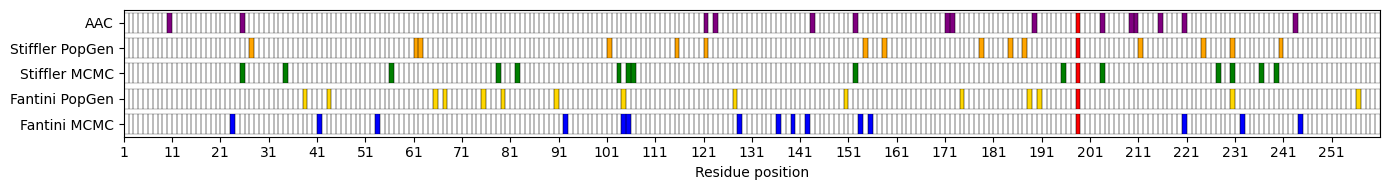

In [12]:
using PyPlot, StatsBase

n_residues = 260
highlight_residue = 198

# Algorithm names (customizable)
alg_names = ["Hed92", "Hed94", "Path to rat-chymo", "Path to bov-chymo", "Mutations model Marion & Sho"]
n_algorithms = length(alg_names)


    # Example predictions (replace with real data)
alg_predictions = [differing_positions(rat_t, hed92),
differing_positions(rat_t, hed94),
differing_positions(rat_t, rat[1].seqs[16]),
differing_positions(rat_t, bov[1].seqs[16]), 
    sho_sites]

#=# Example predictions (replace with real data)
alg_predictions = [differing_positions(rat_t, hed92),
differing_positions(rat_t, hed94), differing_positions(rat_t, hed92),
differing_positions(rat_t, hed94),   hed_sites]=#



# Algorithm colors
colors = ["blue", "gold", "green", "orange", "purple"]

# Start plot
plt.figure(figsize=(14, 2))
ax = plt.gca()

# Plot rectangles
for (i, pred_sites) in enumerate(alg_predictions)
    for pos in pred_sites
        color = pos == highlight_residue ? "red" : colors[i]
        plt.gca().add_patch(plt.Rectangle((pos, i - 0.4), 1, 0.8, color=color, linewidth=0))
    end
end

# Draw contour grid
for i in 1:n_algorithms
    for pos in 1:n_residues
        plt.gca().add_patch(plt.Rectangle((pos, i - 0.4), 1, 0.8, fill=false, edgecolor="black", linewidth=0.2))
    end
end

# Add ticks and labels
plt.xticks(1:10:n_residues)  # every 5 residues; change to 1:10:n_residues if needed
plt.yticks(1:n_algorithms, alg_names)
plt.xlabel("Residue position")

# Limit axes
plt.xlim(1, n_residues + 1)
plt.ylim(0.5, n_algorithms + 0.5)


# Improve layout
plt.tight_layout()

# Save and show
plt.savefig("../residue_importance_map.png", dpi=300)
plt.show()


In [ ]:
n_residues = 260
highlight_residue = 198

# Algorithm names (customizable)
alg_names = ["Hed92", "Hed94", "Path to rat-chymo", "Path to bov-chymo", "Hed94 ppt Marion & Sho"]
n_algorithms = length(alg_names)


    # Example predictions (replace with real data)
alg_predictions = [differing_positions(rat_t, hed92),
differing_positions(rat_t, hed94),
differing_positions(rat_t, rat[1].seqs[16]),
differing_positions(rat_t, bov[1].seqs[16]), 
    hed_sites]



# Algorithm colors
colors = ["blue", "gold", "green", "orange", "purple"]

# Start plot
plt.figure(figsize=(14, 2))
ax = plt.gca()

# Plot rectangles
for (i, pred_sites) in enumerate(alg_predictions)
    for pos in pred_sites
        color = pos == highlight_residue ? "red" : colors[i]
        plt.gca().add_patch(plt.Rectangle((pos, i - 0.4), 1, 0.8, color=color, linewidth=0))
    end
end

# Draw contour grid
for i in 1:n_algorithms
    for pos in 1:n_residues
        plt.gca().add_patch(plt.Rectangle((pos, i - 0.4), 1, 0.8, fill=false, edgecolor="black", linewidth=0.2))
    end
end

# Add ticks and labels
plt.xticks(1:10:n_residues)  # every 5 residues; change to 1:10:n_residues if needed
plt.yticks(1:n_algorithms, alg_names)
plt.xlabel("Residue position")

# Limit axes
plt.xlim(1, n_residues + 1)
plt.ylim(0.5, n_algorithms + 0.5)


# Improve layout
plt.tight_layout()

# Save and show
plt.savefig("../residue_importance_map_control.png", dpi=300)
plt.show()
